# Part 1: EDA

Importing Libraries

In [33]:
# Here we are importing Library which are required 
import pandas as pd
import numpy as np
import math
import datetime as dt
import os
import matplotlib.pyplot as plt
from itertools import cycle
import plotly.graph_objects as go
import plotly.express as px
from plotly.subplots import make_subplots
import seaborn as sns
from statsmodels.graphics.tsaplots import plot_pacf, plot_acf
from statsmodels.tsa.stattools import adfuller
from statsmodels.tsa.seasonal import seasonal_decompose
from datetime import date 

In [34]:
general_path = globals()['_dh'][0]    #The path to the main folder

# read the dataset
data = pd.read_csv(os.path.join(general_path,"Btc_small.csv"))
data

,Date,Open
0,2014-09-17,465.864014
1,2014-09-18,456.859985
2,2014-09-19,424.102997
3,2014-09-20,394.673004
4,2014-09-21,408.084991
...,...,...
832,2016-12-27,908.354004
833,2016-12-28,934.830994
834,2016-12-29,975.125000
835,2016-12-30,972.534973


Set the train and test dataframes

In [35]:
train_size = len(data)-60
train = data[:train_size].copy()

backup = train.copy()
train.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 777 entries, 0 to 776
Data columns (total 2 columns):
 #   Column  Non-Null Count  Dtype  
---  ------  --------------  -----  
 0   Date    777 non-null    object 
 1   Open    777 non-null    float64
dtypes: float64(1), object(1)
memory usage: 12.3+ KB


Text(0, 0.5, 'BTC Price')

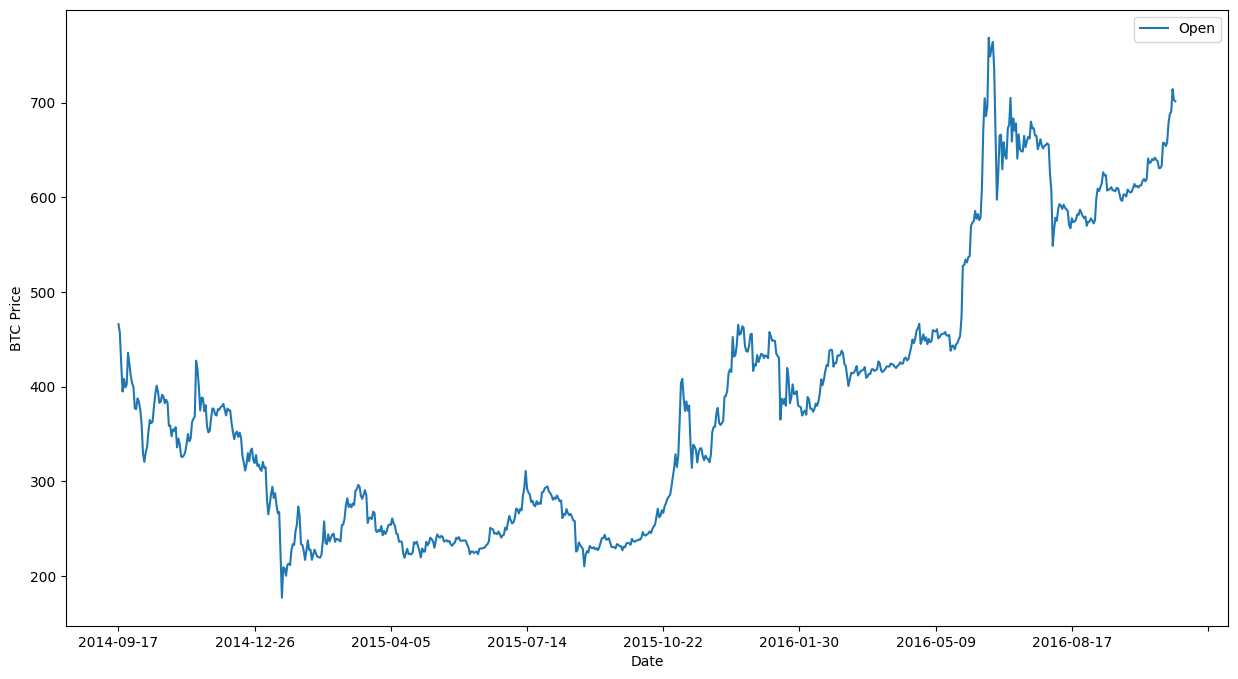

In [36]:
# plot the row data
#plt.figure(figsize=(15, 8))
train.plot(x='Date', y='Open', kind='line', figsize=(15,8))

plt.xlabel('Date')
plt.ylabel('BTC Price')


Text(0.5, 1.0, 'Correlation Heatmap')

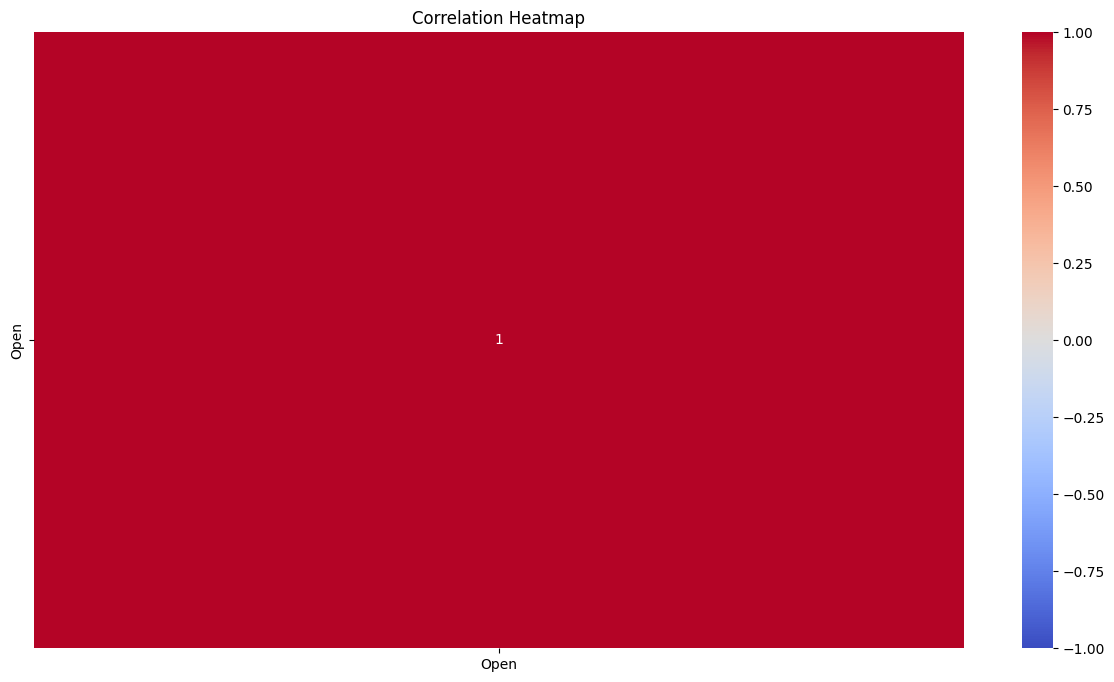

In [37]:
# analyze the correlation between variables, we have only one variable so the corelation will be 1
correlation = train.corr(method='pearson', numeric_only=True)
plt.figure(figsize=(15, 8))
sns.heatmap(correlation, annot=True, cmap='coolwarm', vmin=-1, vmax=1)
plt.title('Correlation Heatmap')

Text(0.5, 1.0, 'Partial Autocorrelation Function (PACF)')

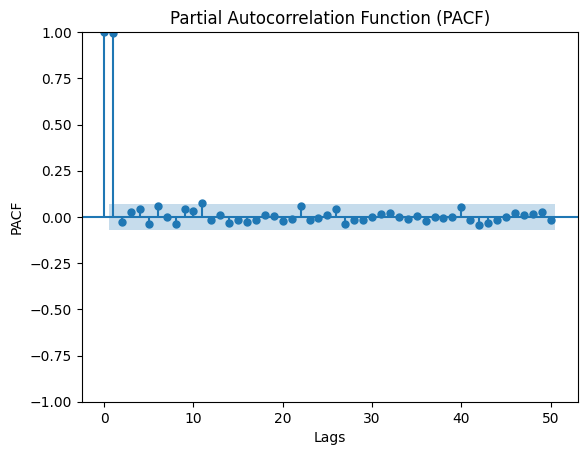

In [38]:

plot_pacf(train['Open'], lags=50)
plt.xlabel('Lags')
plt.ylabel('PACF')
plt.title('Partial Autocorrelation Function (PACF)')

Text(0.5, 1.0, 'Autocorrelation Function (ACF)')

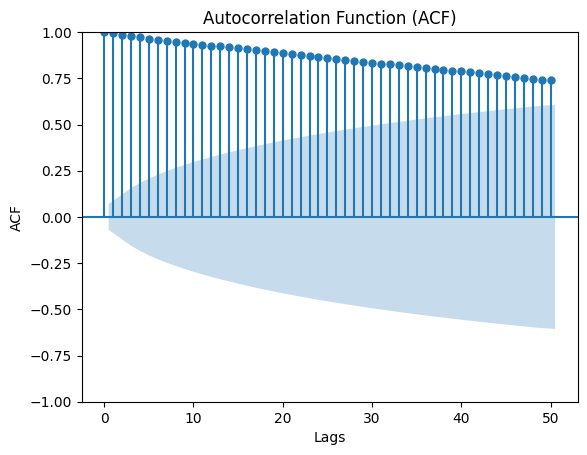

In [39]:

plot_acf(train['Open'], lags=50)
plt.xlabel('Lags')
plt.ylabel('ACF')
plt.title('Autocorrelation Function (ACF)')

<Axes: xlabel='sin_day', ylabel='cos_day'>

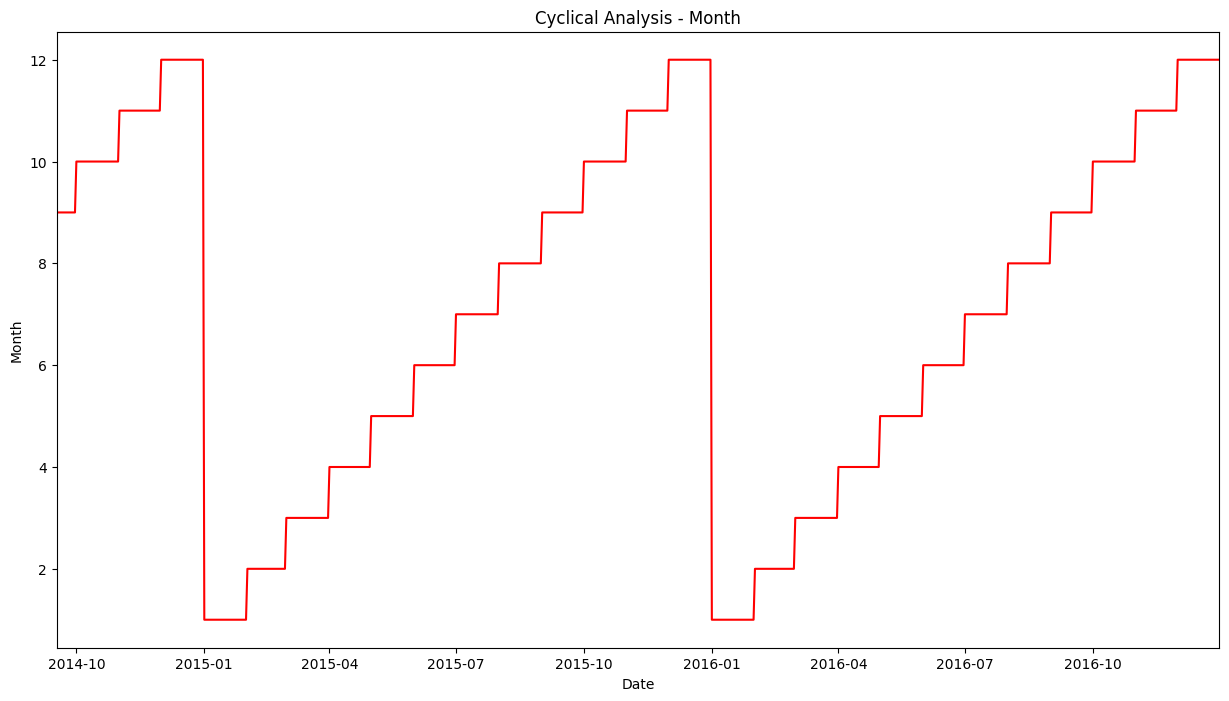

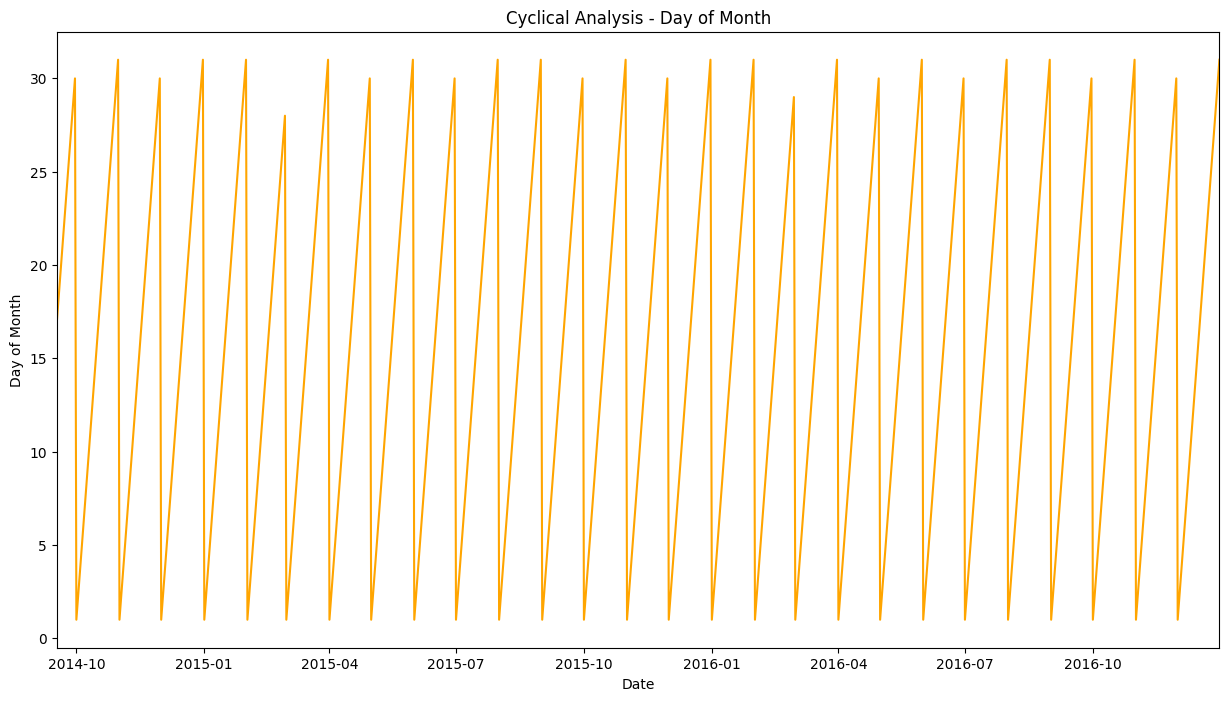

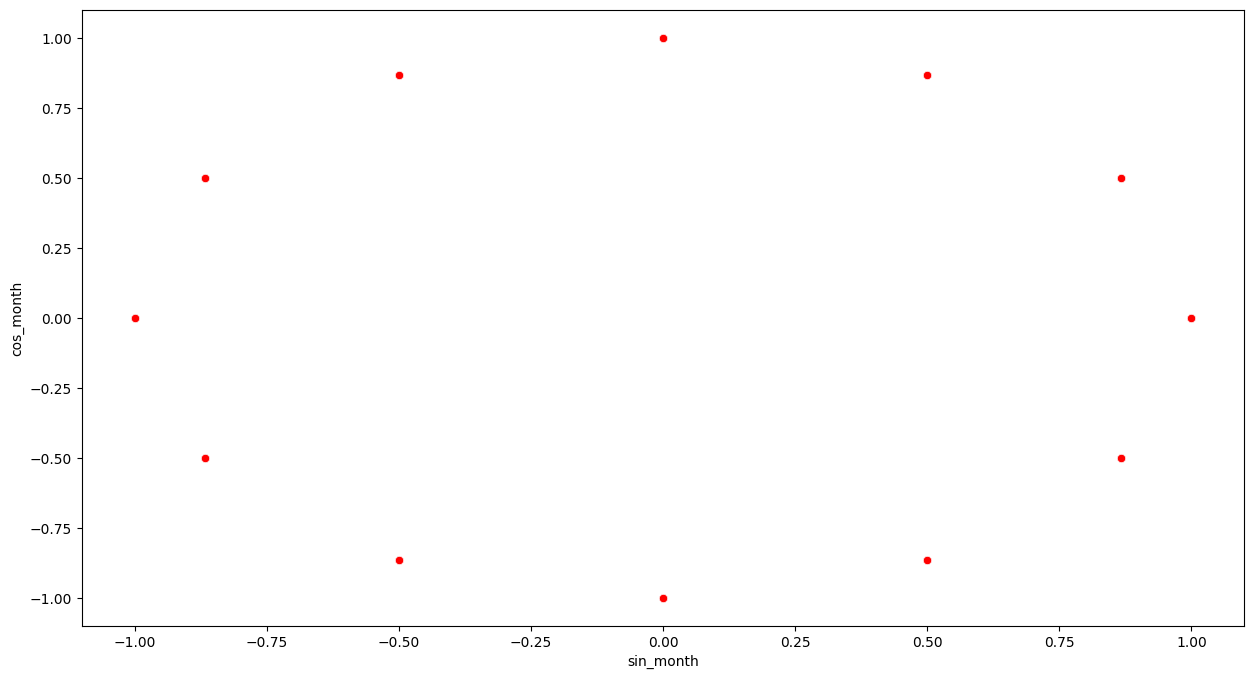

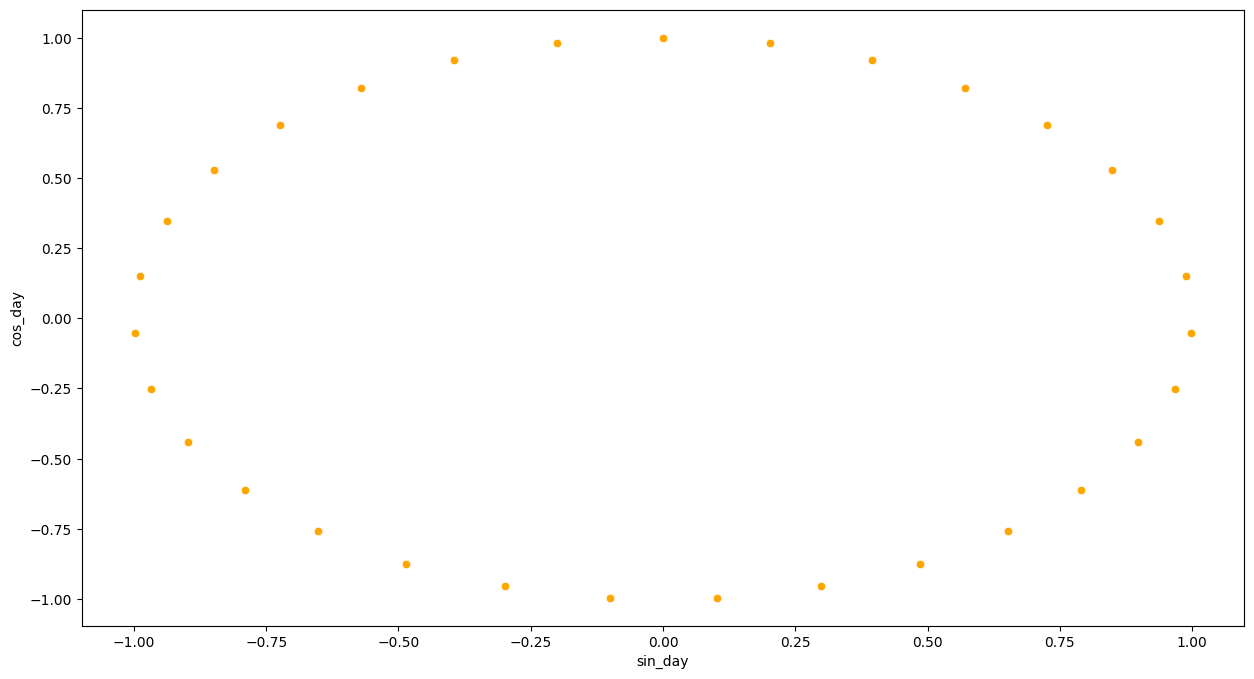

In [40]:
# Handling of cyclical features

# Convert the 'date' column to pandas DateTime format if it's not already in that format
data['Date'] = pd.to_datetime(data['Date'])
train['Date'] = pd.to_datetime(train['Date'])

# Extract components from the date column
data['year'] = data['Date'].dt.year
data['month'] = data['Date'].dt.month
data['day'] = data['Date'].dt.day

# Plot cyclical analysis
fig, ax1 = plt.subplots(figsize=(15, 8))
sns.lineplot(x=data['Date'], y=data['month'], color='red')
ax1.set_xlim([date(2014, 9, 17), date(2016, 12, 31)])
ax1.set_xlabel('Date')
ax1.set_ylabel('Month')
ax1.set_title('Cyclical Analysis - Month')

# Plot cyclical analysis for day of month
fig, ax2 = plt.subplots(figsize=(15, 8))
sns.lineplot(x=data['Date'], y=data['day'], ax=ax2, color='orange')
ax2.set_xlim([date(2014, 9, 17), date(2016, 12, 31)])
ax2.set_xlabel('Date')
ax2.set_ylabel('Day of Month')
ax2.set_title('Cyclical Analysis - Day of Month')



# derive the trigonometric cycles from the components of date
data['month_rad'] = 2 * np.pi * (data['month'] - 1) / 12
data['day_rad'] = 2 * np.pi * (data['day'] - 1) / 31

# Apply sine and cosine transformations
data['sin_month'] = np.sin(data['month_rad'])
data['cos_month'] = np.cos(data['month_rad'])
data['sin_day'] = np.sin(data['day_rad'])
data['cos_day'] = np.cos(data['day_rad'])

# Drop the intermediate columns (month_rad and day_rad) if needed
data = data.drop(['month_rad', 'day_rad'], axis=1)

# plot the graphs of trigo points

# month
f, ax1 = plt.subplots(nrows=1, ncols=1, figsize=(15, 8))
sns.scatterplot(x=data['sin_month'], y=data['cos_month'], color='red')

# day
f, ax2 = plt.subplots(nrows=1, ncols=1, figsize=(15, 8))
sns.scatterplot(x=data['sin_day'], y=data['cos_day'], color='orange')
#plt.show()

In [41]:
def DF_test(series):

    # Perform Dickey-Fuller test:
    print('Results of Dickey-Fuller Test:')
    test_result = adfuller(series)
    
    dfoutput = pd.Series(test_result[0:4], index=['Test Statistic','p-value','#Lags Used','Number of Observations Used'])
    for key,value in test_result[4].items():
        dfoutput['Critical Value (%s)'%key] = value
    print(dfoutput)

    if(dfoutput['p-value'] <= 0.05):
        print("Data is stationary")
    else:
        print("Data is not stationary")


DF_test(train['Open'])

Results of Dickey-Fuller Test:
Test Statistic                   0.129085
p-value                          0.967992
#Lags Used                      11.000000
Number of Observations Used    765.000000
Critical Value (1%)             -3.438927
Critical Value (5%)             -2.865325
Critical Value (10%)            -2.568786
dtype: float64
Data is not stationary


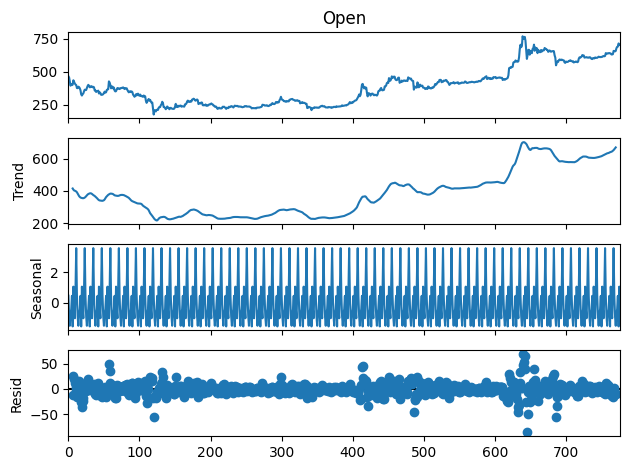

In [42]:
# to find seasonal decomposition
def s_decomp(dframe):
    
    # Perform seasonal decomposition
    decomposition = seasonal_decompose(train['Open'], model='additive', period=12)


    # Original time series
    # plt.subplot(4, 1, 1)
    # plt.plot(train['Open'])
    # plt.title('Original Time Series')

    # Trend component
    trend = decomposition.trend


    # Seasonal component
    seasonal = decomposition.seasonal
    

    # Residual component
    residual = decomposition.resid
  
    decomposition.plot()
    #plt.show()

    return seasonal, trend, residual

seasonal, trend, residual = s_decomp(train[:25])

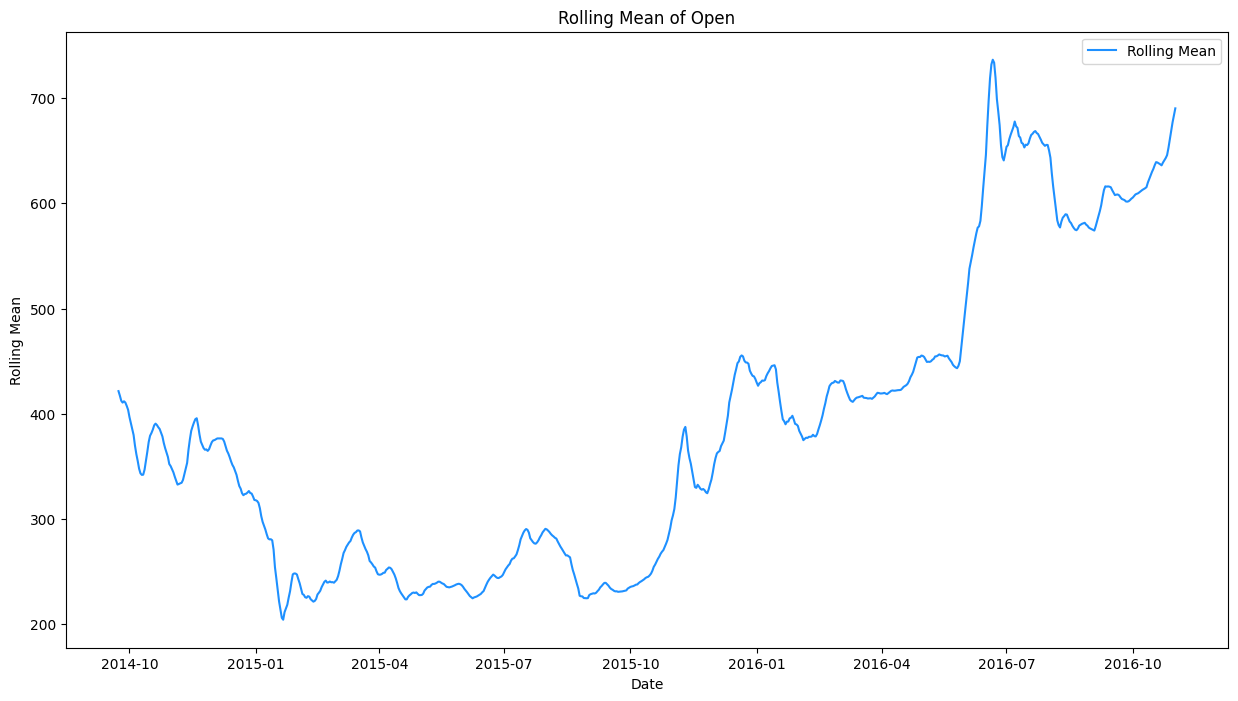

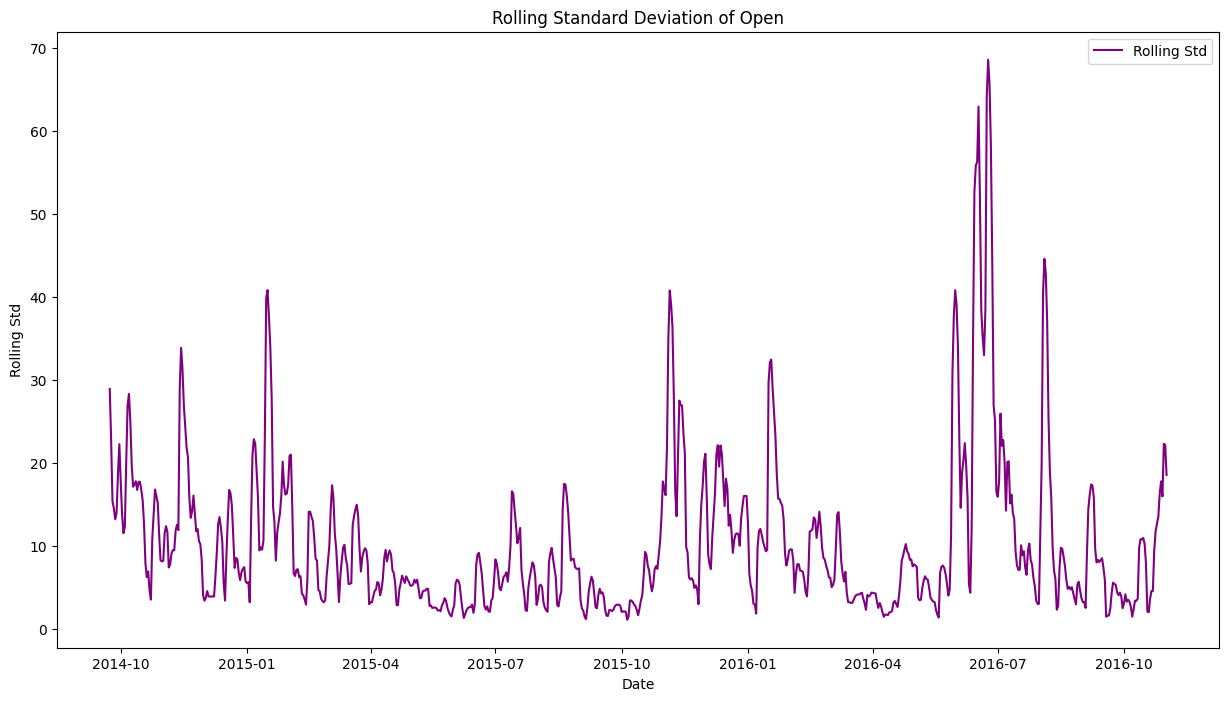

In [43]:
# Apply rolling window statistics to 'Open' column
train['rolling_mean'] = train['Open'].rolling(window=7).mean()
train['rolling_std'] = train['Open'].rolling(window=7).std()

# Plot the rolling mean
plt.figure(figsize=(15, 8))
plt.plot(train['Date'], train['rolling_mean'], label='Rolling Mean', color='dodgerblue')
plt.xlabel('Date')
plt.ylabel('Rolling Mean')
plt.title('Rolling Mean of Open')
plt.legend()
#plt.show()

# Plot the rolling standard deviation
plt.figure(figsize=(15, 8))
plt.plot(train['Date'], train['rolling_std'], label='Rolling Std', color='purple')
plt.xlabel('Date')
plt.ylabel('Rolling Std')
plt.title('Rolling Standard Deviation of Open')
plt.legend()

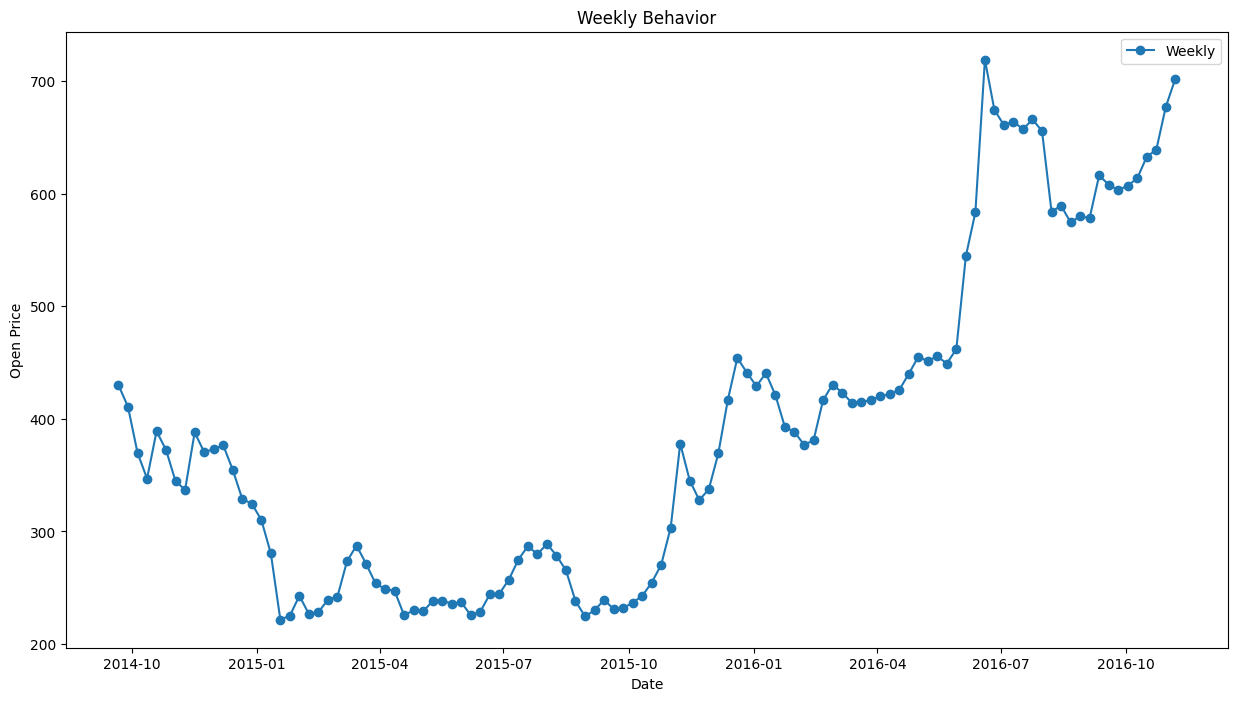

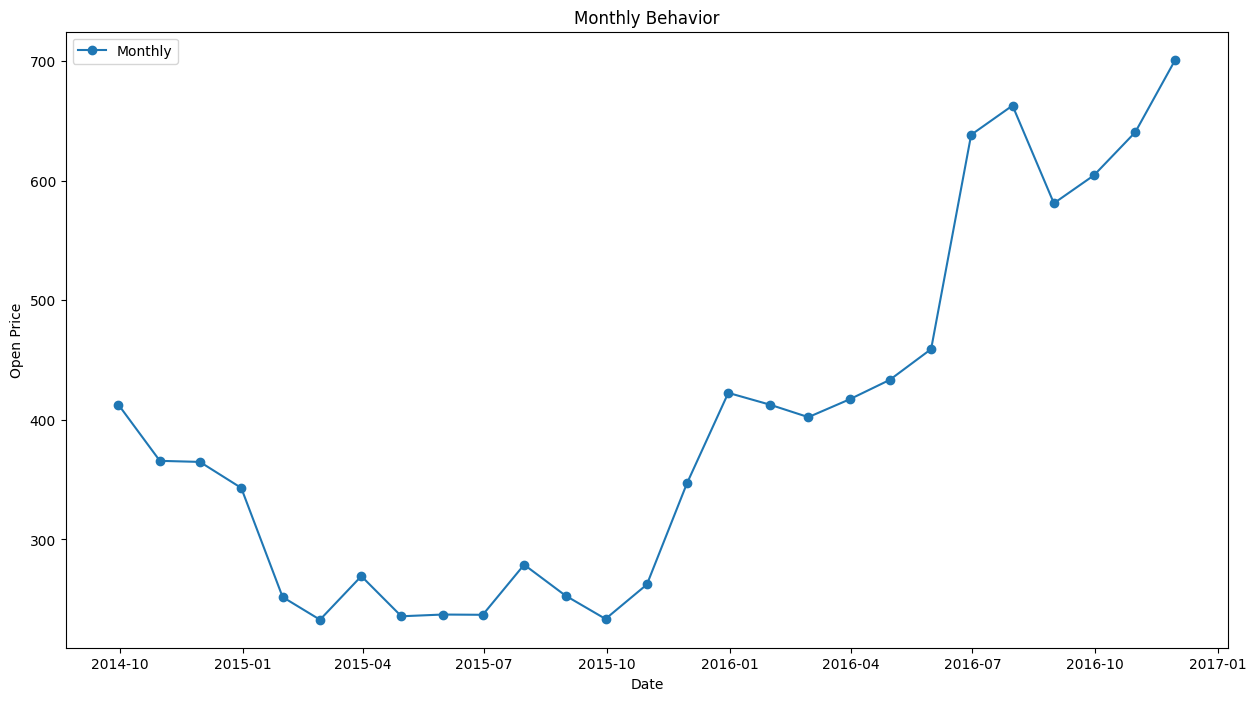

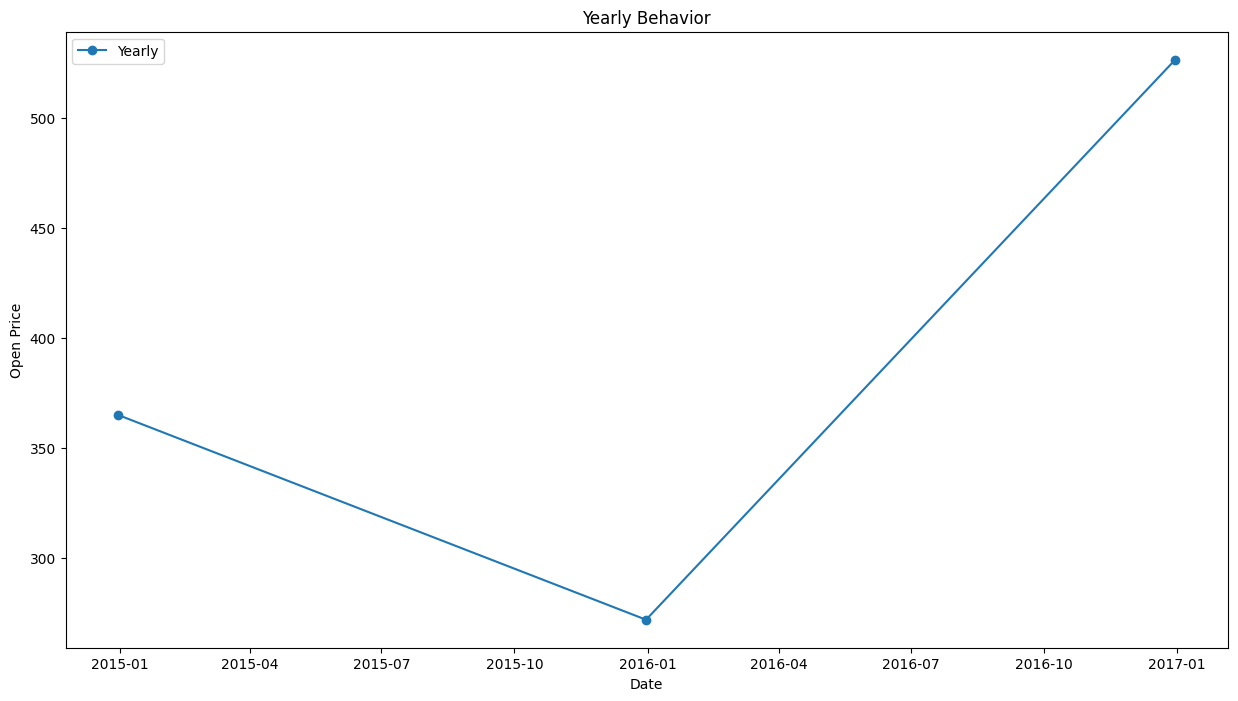

In [44]:
# observe the weekly, monthly, yearly behavior of the data

# Convert the 'Date' column to pandas DateTime format
backup['Date'] = pd.to_datetime(data['Date'])

# Set the 'Date' column as the index
backup.set_index('Date', inplace=True)

# Resample the data to weekly, monthly, and yearly frequency
weekly_data = backup['Open'].resample('W').mean()
monthly_data = backup['Open'].resample('M').mean()
yearly_data = backup['Open'].resample('Y').mean()

# Plot the weekly data
plt.figure(figsize=(15, 8))
plt.plot(weekly_data, marker='o', linestyle='-', label='Weekly')
plt.xlabel('Date')
plt.ylabel('Open Price')
plt.title('Weekly Behavior')
plt.legend()
#plt.show()

# Plot the monthly data
plt.figure(figsize=(15, 8))
plt.plot(monthly_data, marker='o', linestyle='-', label='Monthly')
plt.xlabel('Date')
plt.ylabel('Open Price')
plt.title('Monthly Behavior')
plt.legend()
#plt.show()

# Plot the yearly data
plt.figure(figsize=(15, 8))
plt.plot(yearly_data, marker='o', linestyle='-', label='Yearly')
plt.xlabel('Date')
plt.ylabel('Open Price')
plt.title('Yearly Behavior')
plt.legend()

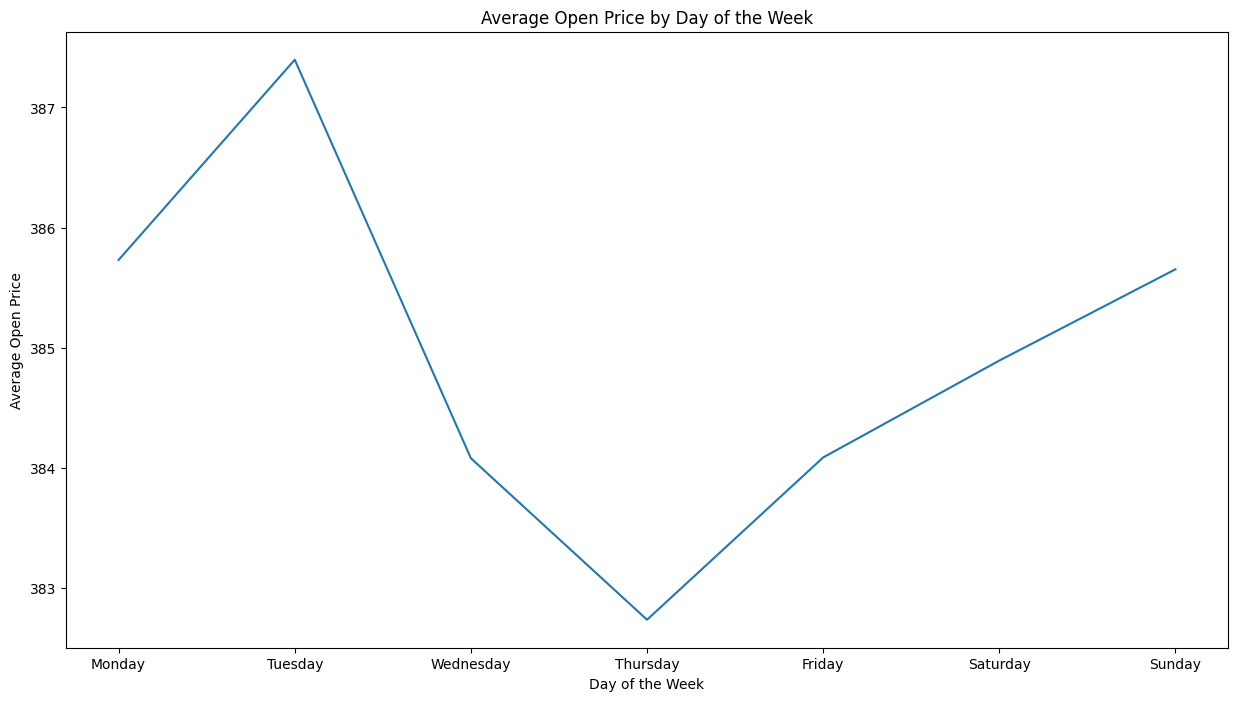

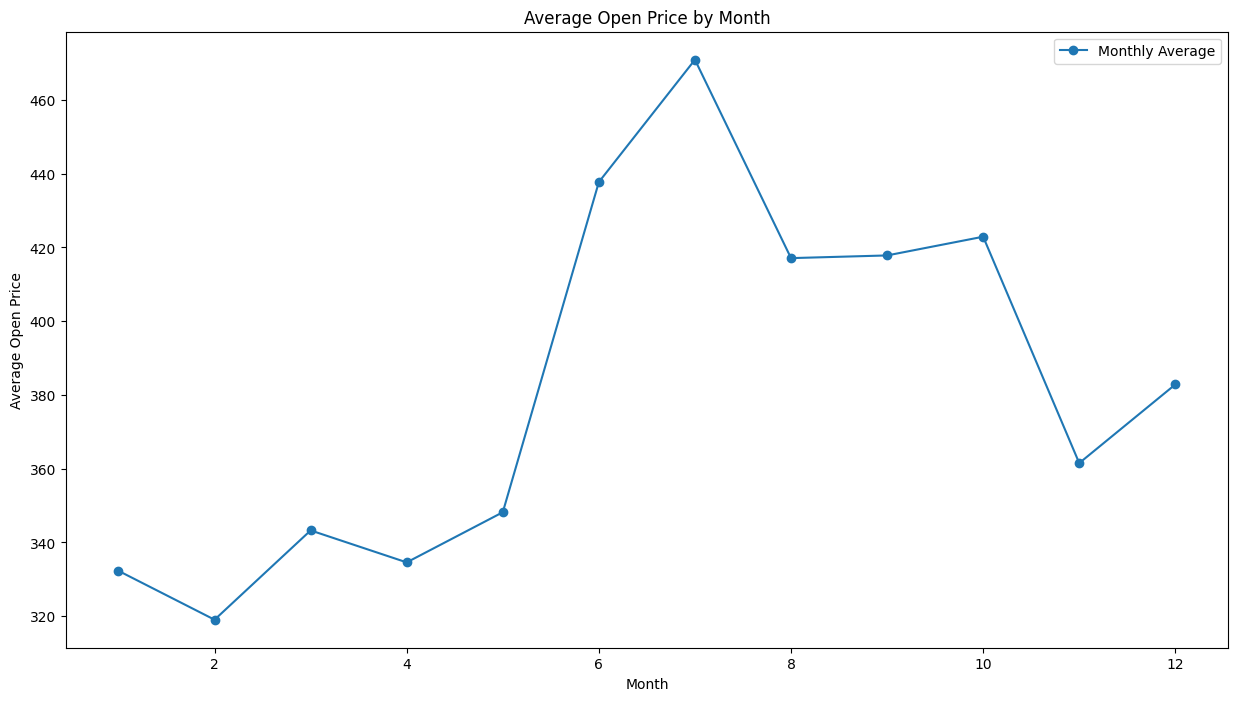

In [45]:
# now get the average target value (Open) for each day of the week (Monday, Tuesday, etc.)

# Calculate the average Open price for each day of the week
daily_avg = backup.groupby(backup.index.weekday)['Open'].mean()

# Plot the result
plt.figure(figsize=(15, 8))
plt.plot(daily_avg.index, daily_avg)
plt.xlabel('Day of the Week')
plt.ylabel('Average Open Price')
plt.title('Average Open Price by Day of the Week')
plt.xticks(range(7), ['Monday', 'Tuesday', 'Wednesday', 'Thursday', 'Friday', 'Saturday', 'Sunday'])
#plt.show()

# Calculate the average Open price for each month
monthly_avg = backup.groupby(backup.index.month)['Open'].mean()


# Plot the result
plt.figure(figsize=(15, 8))
plt.plot(monthly_avg.index, monthly_avg, marker='o', linestyle='-', label='Monthly Average')
plt.xlabel('Month')
plt.ylabel('Average Open Price')
plt.title('Average Open Price by Month')
plt.legend()
#plt.show()

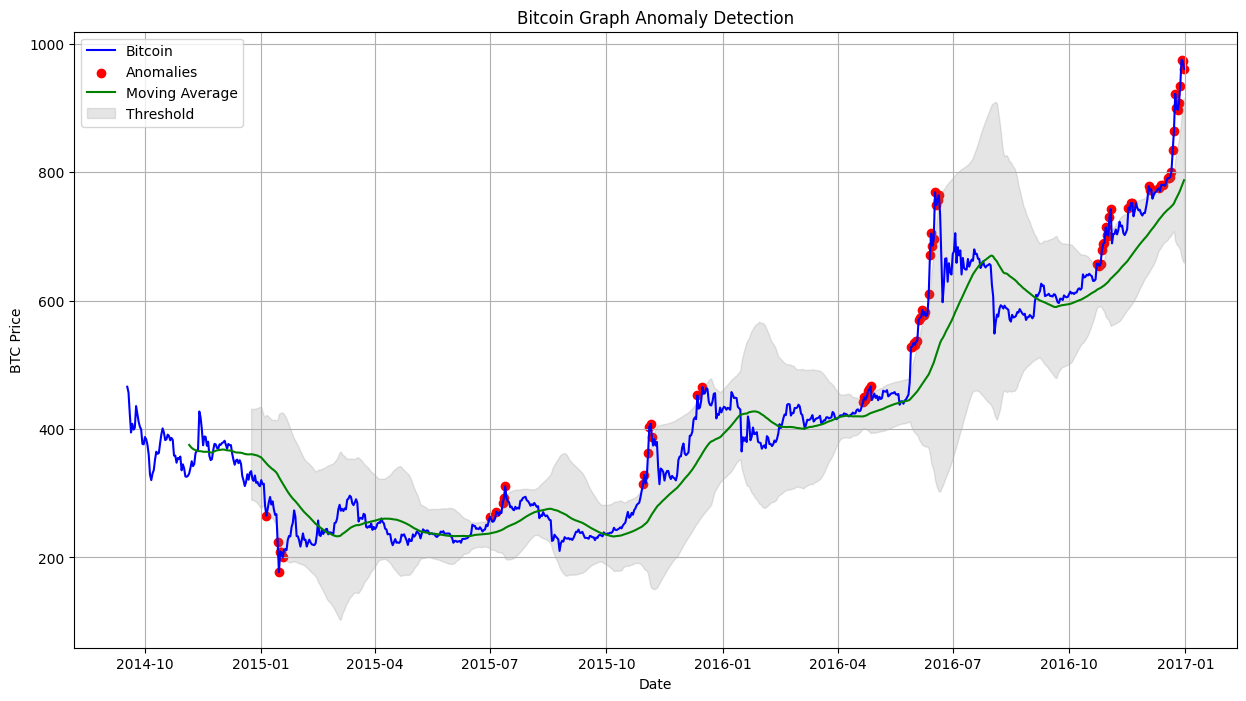

In [46]:
# Anomaly Detection

# Calculate the moving average of the temperature readings
window_size = 50 # MODIFICATION, 50
ma = data['Open'].rolling(window_size).mean()

# Calculate the deviation from the moving average
deviation = data['Open'] - ma

# Calculate the standard deviation of the deviation
std_deviation = deviation.rolling(window_size).std()

# Calculate the threshold for anomaly detection
threshold = 3 * std_deviation
#print(threshold)
# Detect anomalies based on deviations from the moving average
anomalies = data[deviation.abs() > threshold]

# Plot the temperature readings and the anomalies
plt.subplots(figsize=(15, 8)) # MODIFICATION, inserted
plt.plot(data['Date'], data['Open'], color='blue', label='Bitcoin')
plt.scatter(anomalies['Date'], anomalies['Open'], color='red', label='Anomalies')
plt.plot(data['Date'], ma, color='green', label='Moving Average')
plt.fill_between(data['Date'], ma-threshold, ma+threshold, color='gray', alpha=0.2, label='Threshold')
plt.legend()
plt.title('Bitcoin Graph Anomaly Detection')
plt.xlabel('Date')
plt.ylabel('BTC Price')
plt.grid() # MODIFICATION, inserted
plt.show()